# CS 437/5317 - Deep Learning - PA3 - Part 2

In this part, we'll work with two datasets:
- STL-10, which is an image recognition dataset of `3x96x96` images. This dataset contains 500 training & 800 testing images per class, along with a massive unlabeled set of 100k images. However, you're only given half of them to ensure that training doesn't take forever lol. You can download it [here](https://pern-my.sharepoint.com/:u:/g/personal/24020389_lums_edu_pk/EcuDNMPuWY5MlIrbG-VwOXYBYNLpHz7MkG2Vw7WKVltnlw?e=E4lDqf).
- A 2D brain tumor segmentation dataset ([download link](https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation)). We'll be using an autoencoder to segment brain tumors from MRI brain images. This dataset contains 3064 pairs of MRI scans and their binary masks indicating tumor.

#### Import the required libraries and load the STL-10 dataset (only the train & test splits; the unlabeled images will be loaded later from the custom Dataset class implementation I've shared):

In [64]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from tqdm.notebook import tqdm
import numpy as np
import torchvision
from torch import nn, optim
from torchsummary import summary
from sklearn.model_selection import train_test_split
from helper import (
    transform,
    training_loop_supervised,
    training_loop_unsupervised,
    training_loop_segmentation,
    noisy_images,
    visualize_reconstructions,
    unlabeled_dataset,
    evaluate
)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128 # feel free to change this





In [38]:
# Load the STL-10 train and test datasets below:

class customSTL10(Dataset):
    def __init__(self, partition, transform=None):

        self.image_paths = sorted(glob.glob("./STL-10/" + partition + '_images/*.png'), key = lambda x: int(x.split('/')[-1].split('_')[-1].split('.')[0]))
        self.labels = np.load('./STL-10/stl10_labels/' + partition + '_labels.npy')
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, index):
        image = cv2.imread(self.image_paths[index])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #ensures that img is rgb
        label = self.labels[index]
        # print(label)

        # print(type(label))
        label = torch.tensor(label)
        # print(label.shape)
        # print(type(label[0]))
        if self.transform:
            image = self.transform(image)

        return image, label


transform_train = transforms.Compose([

    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),


    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))



])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = customSTL10(partition='train', transform=transform_train)
test_dataset = customSTL10(partition='test', transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### For now, we'll only work with the labeled data for supervised training. Let's visualize the data:

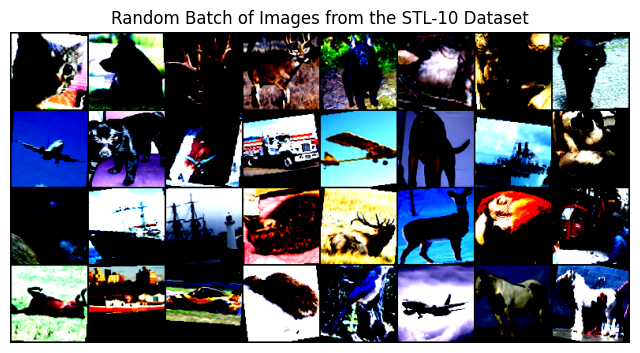

In [8]:
def imshow(img):
    img = img
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Random Batch of Images from the STL-10 Dataset")
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[0:32]))
# airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck


## Task 1: Supervised Learning

Train a CNN Classifier on the training data and evaluate it on the test data. Add Convolutional layers, Batch Normalization, and Pooling layers in the convolutional block followed by a classifier layer.

In [27]:






class ClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # nn.Dropout(0.2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # nn.Dropout(0.2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(64*6*6, 100),
            nn.ReLU(),

        )
        self.classifier = nn.Sequential(
            nn.Linear(100, 10),
            # nn.Dropout(dropout_rate),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # Code here
        x = self.encoder(x)

        x = self.classifier(x)
        return x


In [28]:
model = ClassifierCNN()
model.to(device)
summary(model, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 96, 96]             216
       BatchNorm2d-2           [128, 8, 96, 96]              16
              ReLU-3           [128, 8, 96, 96]               0
         MaxPool2d-4           [128, 8, 48, 48]               0
            Conv2d-5          [128, 16, 48, 48]           1,152
       BatchNorm2d-6          [128, 16, 48, 48]              32
              ReLU-7          [128, 16, 48, 48]               0
         MaxPool2d-8          [128, 16, 24, 24]               0
            Conv2d-9          [128, 32, 24, 24]           4,608
      BatchNorm2d-10          [128, 32, 24, 24]              64
             ReLU-11          [128, 32, 24, 24]               0
        MaxPool2d-12          [128, 32, 12, 12]               0
           Conv2d-13          [128, 64, 12, 12]          18,432
      BatchNorm2d-14          [128, 64,

#### Train your Model & Plot the Test accuracy history:

In [29]:
# Code here
model = ClassifierCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
#./PA3-2_Part2_Task1_STL10_CNN_Classifier_24100043.pth
model_path= "./STL-10_CNN_classifier_basic.pth"
# checkpoint = torch.load(model_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
num_epochs = 40
train_hist, test_hist = training_loop_supervised(model, train_loader, test_loader, num_epochs, criterion, optimizer, device, model_path)


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Train Loss: 0.004146, Train Accuracy: 0.258200
Test Loss: 0.016887, Test Accuracy: 0.365625
Epoch: 2/40, Train Loss: 0.003777, Train Accuracy: 0.394400
Test Loss: 0.016319, Test Accuracy: 0.389875
Epoch: 3/40, Train Loss: 0.003874, Train Accuracy: 0.428600
Test Loss: 0.016391, Test Accuracy: 0.416125
Epoch: 4/40, Train Loss: 0.003580, Train Accuracy: 0.451200
Test Loss: 0.016395, Test Accuracy: 0.404750
Epoch: 5/40, Train Loss: 0.003685, Train Accuracy: 0.469400
Test Loss: 0.015941, Test Accuracy: 0.456125
Epoch: 6/40, Train Loss: 0.003949, Train Accuracy: 0.474600
Test Loss: 0.016119, Test Accuracy: 0.462125
Epoch: 7/40, Train Loss: 0.003538, Train Accuracy: 0.486200
Test Loss: 0.016062, Test Accuracy: 0.468125
Epoch: 8/40, Train Loss: 0.003272, Train Accuracy: 0.487200
Test Loss: 0.016075, Test Accuracy: 0.453250
Epoch: 9/40, Train Loss: 0.003705, Train Accuracy: 0.506400
Test Loss: 0.015890, Test Accuracy: 0.479500
Epoch: 10/40, Train Loss: 0.003237, Train Accuracy: 0.5

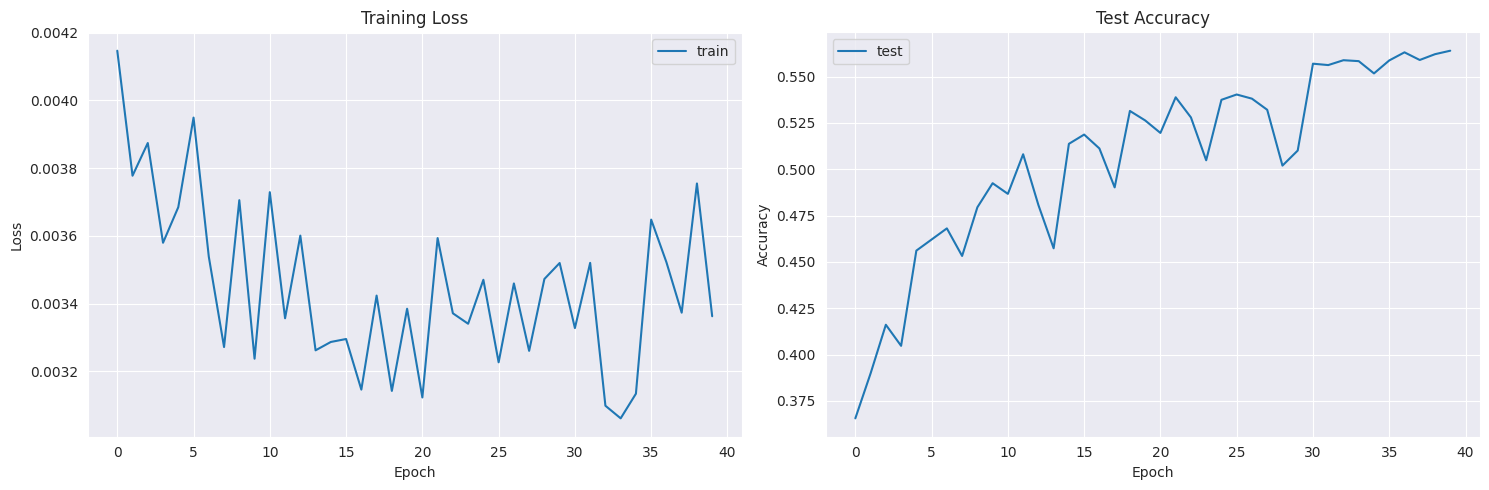

In [33]:




plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

sns.set_style(style="darkgrid")
train_hist = np.array([tensor.item() for tensor in train_hist])
sns.lineplot(data=train_hist, label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")


plt.subplot(1, 2, 2)
sns.set_style(style="darkgrid")
test_hist = np.array([tensor.item() for tensor in test_hist])
sns.lineplot(data=test_hist, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.tight_layout()
plt.show()




### Small fun task: Let's evaluate a pre-trained Model (ResNET18) on the STL-10 data and see what accuracy we can achieve.

To use a pre-trained model, we first import it and its weights from `torchvision.models` and freeze the gradients of all the layers (because we want to use its learned embeddings that are trained on a massive dataset such as ImageNet) and then replace the final classifier layer with one that suits our specific problem (e.g. 10 classes in our case instead of the 1000 ImageNet Classes it's trained on).

In [34]:
from torchvision.models import resnet18, ResNet18_Weights

#### Read the documentation of this model. Look up the process of using a pre-trained model for your own dataset, and then train it on our labeled data.

In [35]:
model = resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]


In [36]:


for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
number_of_features = model.fc.in_features
model.fc = nn.Linear(number_of_features, 10)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
summary(model, input_size=(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),

    transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),


    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

])

train_dataset = customSTL10(partition='train', transform=transform)
test_dataset = customSTL10(partition='test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Train ResNet-18 & Plot the Accuracy History

In [38]:

# Code Here
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model_path = "./resnet_classifier_PA3_rollnumber.pth"
num_epochs = 20
train_hist, test_hist = training_loop_supervised(model, train_loader, test_loader, num_epochs,
                                                 criterion, optimizer, device, model_path)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 0.003753, Train Accuracy: 0.112000
Test Loss: 0.018275, Test Accuracy: 0.165500
Epoch: 2/20, Train Loss: 0.003943, Train Accuracy: 0.213800
Test Loss: 0.016018, Test Accuracy: 0.269000
Epoch: 3/20, Train Loss: 0.003039, Train Accuracy: 0.310000
Test Loss: 0.015110, Test Accuracy: 0.367750
Epoch: 4/20, Train Loss: 0.003483, Train Accuracy: 0.417800
Test Loss: 0.013102, Test Accuracy: 0.444375
Epoch: 5/20, Train Loss: 0.002305, Train Accuracy: 0.480400
Test Loss: 0.011999, Test Accuracy: 0.508125
Epoch: 6/20, Train Loss: 0.002842, Train Accuracy: 0.544800
Test Loss: 0.011743, Test Accuracy: 0.543375
Epoch: 7/20, Train Loss: 0.002779, Train Accuracy: 0.586200
Test Loss: 0.010827, Test Accuracy: 0.583750
Epoch: 8/20, Train Loss: 0.003114, Train Accuracy: 0.603400
Test Loss: 0.010627, Test Accuracy: 0.612500
Epoch: 9/20, Train Loss: 0.002135, Train Accuracy: 0.641600
Test Loss: 0.009846, Test Accuracy: 0.629250
Epoch: 10/20, Train Loss: 0.003047, Train Accuracy: 0.6

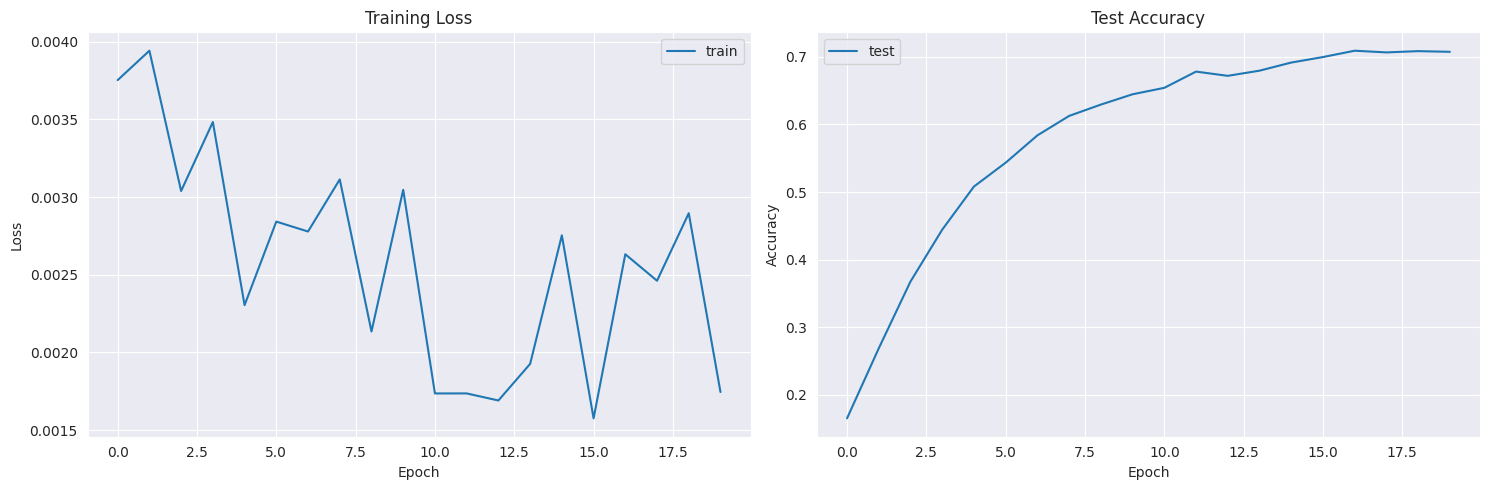

In [39]:




plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

sns.set_style(style="darkgrid")
train_hist = np.array([tensor.item() for tensor in train_hist])
sns.lineplot(data=train_hist, label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")


plt.subplot(1, 2, 2)
sns.set_style(style="darkgrid")
test_hist = np.array([tensor.item() for tensor in test_hist])
sns.lineplot(data=test_hist, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.tight_layout()
plt.show()




## Task 2: Training an AutoEncoder with Unlabeled Data for Prediciton on Labeled Data

#### Anyway, back to creating our own models. In the next task, we will attempt to harness the power of self-supervised learning using an AutoEncoder.

The idea is to train a model to reconstruct (massive amounts of) unlabeled data in an unsupervised manner, and then use the encoder's learned embeddings to train the model on limited training data.

For this task, we will create a Deep Encoder-Decoder convolutional model. We'll train it on the unlabeled images from the STL-10 dataset, and then use the encoder with a classifier in another model class for classification.

**Note:** I recommend not using any pooling layers, as that leads to complications with storing the indices and putting them back into Unpooling layers. Just use a convolutional architecture.

In [49]:

class EncoderDecoderCNN(nn.Module):
    def __init__(self, in_chans=3, dropout_rate=0.2):
        super(EncoderDecoderCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_chans, out_channels=16, kernel_size=3, stride=1, padding=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=in_chans, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [50]:
# load the model
model = EncoderDecoderCNN()
model.to(device)
summary(model, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 98, 98]             448
            Conv2d-2        [128, 16, 100, 100]           2,304
       BatchNorm2d-3        [128, 16, 100, 100]              32
              ReLU-4        [128, 16, 100, 100]               0
         MaxPool2d-5          [128, 16, 50, 50]               0
            Conv2d-6          [128, 32, 50, 50]           4,640
            Conv2d-7          [128, 32, 50, 50]           9,216
       BatchNorm2d-8          [128, 32, 50, 50]              64
              ReLU-9          [128, 32, 50, 50]               0
        MaxPool2d-10          [128, 32, 25, 25]               0
           Conv2d-11          [128, 64, 25, 25]          18,496
           Conv2d-12          [128, 64, 25, 25]          36,864
      BatchNorm2d-13          [128, 64, 25, 25]             128
             ReLU-14          [128, 64,

### Load the Dataset and train your AE model

In [54]:
folder = "./STL-10/unlabeled_images" # change this to where your folder is

ram_above_16 = True # Set this to True if you have >= 16GB RAM

UnlabeledImageDataset = unlabeled_dataset(ram_above_16)
train_dataset = UnlabeledImageDataset(folder=folder, split='train')
val_dataset = UnlabeledImageDataset(folder=folder, split='val')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

40000
10000


### Train Your Model

In [51]:
# Code here

model = EncoderDecoderCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)
#./PA3-2_Part2_Task2_STL10_AE_recon_24100043.pth
model_path = "./STL10_CNN_autoencoder_reconstruction.pth"
num_epochs = 20
train_hist, test_hist = training_loop_unsupervised(model, "reconstruction", train_loader, test_loader, num_epochs,
                                                   criterion, optimizer, device, model_path)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 0.000098
Test Loss: 0.000385
Epoch: 2/20, Train Loss: 0.000057
Test Loss: 0.000255
Epoch: 3/20, Train Loss: 0.000036
Test Loss: 0.000227
Epoch: 4/20, Train Loss: 0.000036
Test Loss: 0.000160
Epoch: 5/20, Train Loss: 0.000022
Test Loss: 0.000129
Epoch: 6/20, Train Loss: 0.000027
Test Loss: 0.000109
Epoch: 7/20, Train Loss: 0.000022
Test Loss: 0.000144
Epoch: 8/20, Train Loss: 0.000032
Test Loss: 0.000103
Epoch: 9/20, Train Loss: 0.000017
Test Loss: 0.000102
Epoch: 10/20, Train Loss: 0.000025
Test Loss: 0.000096
Epoch: 11/20, Train Loss: 0.000021
Test Loss: 0.000093
Epoch: 12/20, Train Loss: 0.000019
Test Loss: 0.000094
Epoch: 13/20, Train Loss: 0.000021
Test Loss: 0.000096
Epoch: 14/20, Train Loss: 0.000031
Test Loss: 0.000105
Epoch: 15/20, Train Loss: 0.000021
Test Loss: 0.000088
Epoch: 16/20, Train Loss: 0.000025
Test Loss: 0.000091
Epoch: 17/20, Train Loss: 0.000041
Test Loss: 0.000096
Epoch: 18/20, Train Loss: 0.000017
Test Loss: 0.000087
Epoch: 19/20, Train

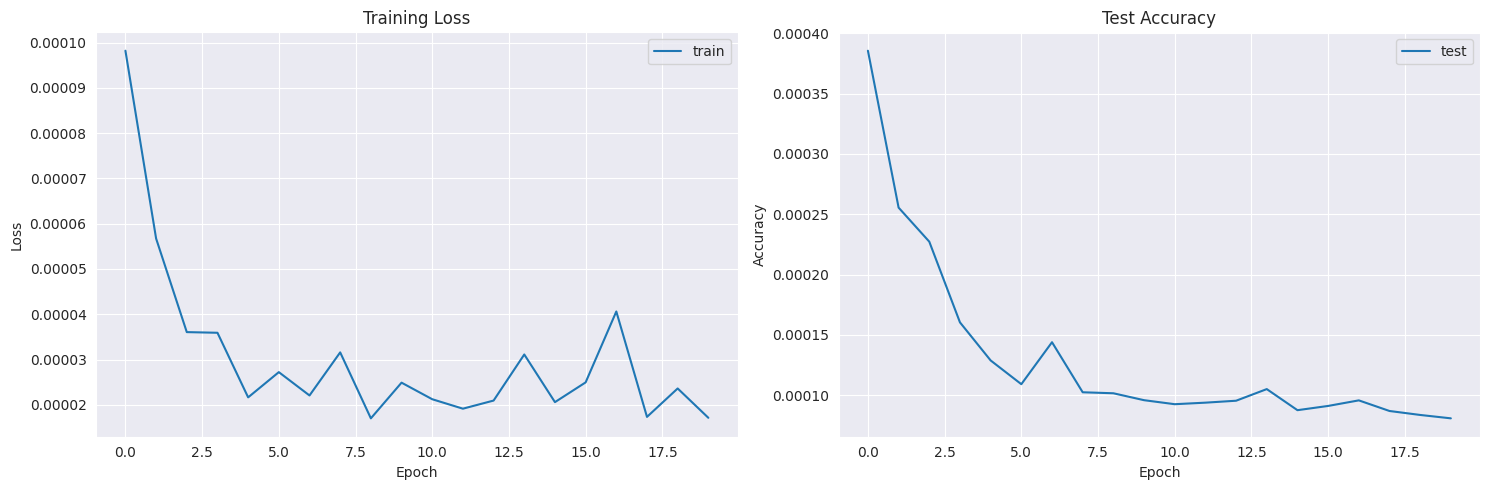

In [52]:




plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

sns.set_style(style="darkgrid")
train_hist = np.array([tensor.item() for tensor in train_hist])
sns.lineplot(data=train_hist, label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")


plt.subplot(1, 2, 2)
sns.set_style(style="darkgrid")
test_hist = np.array([tensor.item() for tensor in test_hist])
sns.lineplot(data=test_hist, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.tight_layout()
plt.show()




### Visualize 9 random images and their reconstructions using `plt.subplots`.

Note: it's fine if they're horrible reconstructions, that's expected from a simple Convolutional AE

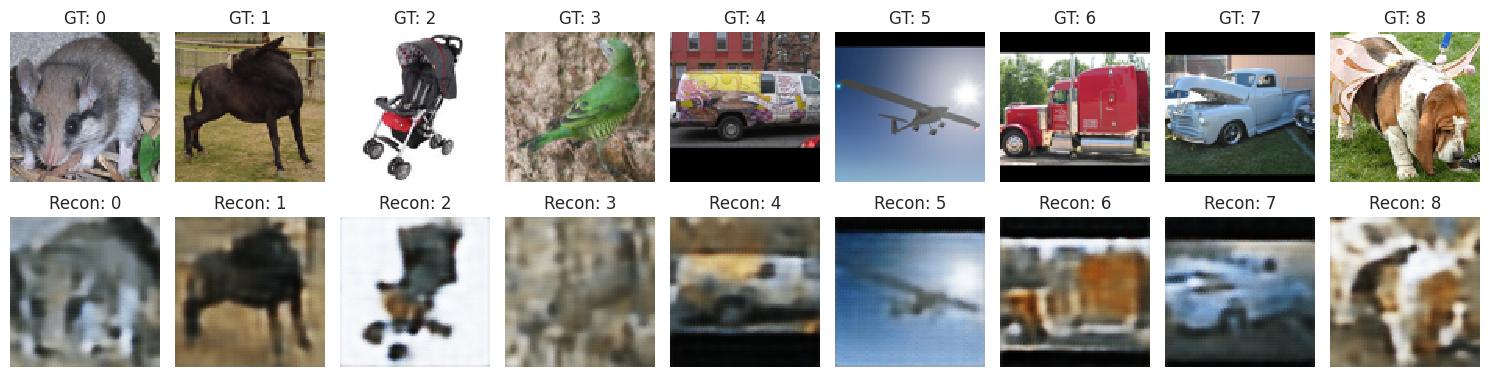

In [57]:
# Code here

#code taken from helper file provided already

model.eval()

dataiter = iter(test_loader)
images = next(dataiter)



recons = model(images.to(device))

images_np = images.cpu().numpy()
recons_np = recons.cpu().detach().numpy()

indices = np.random.choice(images_np.shape[0], 9, replace=False)
selected_images = images_np[indices]
selected_recons = recons_np[indices]
# selected_labels = labels.numpy()[indices]

fig, axs = plt.subplots(2, 9, figsize=(15, 4))

for i in range(9):
    axs[0, i].imshow(np.transpose(selected_images[i], (1, 2, 0)), interpolation='none', cmap='gray')
    axs[0, i].set_title(f"GT: {i}")
    axs[0, i].axis('off')

    axs[1, i].imshow(np.transpose(selected_recons[i], (1, 2, 0)), interpolation='none', cmap='gray')
    axs[1, i].set_title(f"Recon: {i}")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()




#### Now, use the encoder from this AE (freeze its gradients) with a classifier layer to train the model.

In [58]:

class EncoderClassifier(nn.Module):
    def __init__(self, encoder, classes=10):
        super(EncoderClassifier, self).__init__()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*6*6, 42),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(42, classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)

        x = self.classifier(x)
        return x




In [59]:
# Declare the model & print a summary

model = EncoderDecoderCNN()
#./PA3-2_Part2_Task2_STL10_AE_recon_24100043.pth
path = "./STL10_CNN_autoencoder_reconstruction.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint)

model = EncoderClassifier(encoder= model.encoder, classes=10)
model.to(device)
summary(model, input_size=(3, 96, 96), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 98, 98]             448
            Conv2d-2        [128, 16, 100, 100]           2,304
       BatchNorm2d-3        [128, 16, 100, 100]              32
              ReLU-4        [128, 16, 100, 100]               0
         MaxPool2d-5          [128, 16, 50, 50]               0
            Conv2d-6          [128, 32, 50, 50]           4,640
            Conv2d-7          [128, 32, 50, 50]           9,216
       BatchNorm2d-8          [128, 32, 50, 50]              64
              ReLU-9          [128, 32, 50, 50]               0
        MaxPool2d-10          [128, 32, 25, 25]               0
           Conv2d-11          [128, 64, 25, 25]          18,496
           Conv2d-12          [128, 64, 25, 25]          36,864
      BatchNorm2d-13          [128, 64, 25, 25]             128
             ReLU-14          [128, 64,

In [60]:
# create dataloaders again for the train and test split of the STL-10 dataset


transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = customSTL10(partition='train', transform=transform)
test_dataset = customSTL10(partition='test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Train your model

In [61]:
# Code here

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#./PA3-2_Part2_Task2_STL_AE_Classifier_24100043.pth
model_path = "./stl-10_encoder_classifier_PA3_rollnumber.pth"
# checkpoint = torch.load(model_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)
num_epochs = 25
train_hist, test_hist = training_loop_supervised(model, train_loader, test_loader, num_epochs,
                                                 criterion, optimizer, device, model_path)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1/25, Train Loss: 0.004051, Train Accuracy: 0.209200
Test Loss: 0.017255, Test Accuracy: 0.288125
Epoch: 2/25, Train Loss: 0.004288, Train Accuracy: 0.316600
Test Loss: 0.016835, Test Accuracy: 0.331375
Epoch: 3/25, Train Loss: 0.004091, Train Accuracy: 0.349200
Test Loss: 0.016597, Test Accuracy: 0.335750
Epoch: 4/25, Train Loss: 0.003959, Train Accuracy: 0.380800
Test Loss: 0.016440, Test Accuracy: 0.360625
Epoch: 5/25, Train Loss: 0.004093, Train Accuracy: 0.404400
Test Loss: 0.016356, Test Accuracy: 0.385250
Epoch: 6/25, Train Loss: 0.003656, Train Accuracy: 0.424000
Test Loss: 0.016377, Test Accuracy: 0.394500
Epoch: 7/25, Train Loss: 0.003869, Train Accuracy: 0.451400
Test Loss: 0.016263, Test Accuracy: 0.407250
Epoch: 8/25, Train Loss: 0.003532, Train Accuracy: 0.457800
Test Loss: 0.016116, Test Accuracy: 0.404625
Epoch: 9/25, Train Loss: 0.003320, Train Accuracy: 0.460800
Test Loss: 0.016409, Test Accuracy: 0.373875
Epoch: 10/25, Train Loss: 0.003391, Train Accuracy: 0.4

In [65]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.6f}")


Test Loss: 0.015940, Test Accuracy: 0.431125


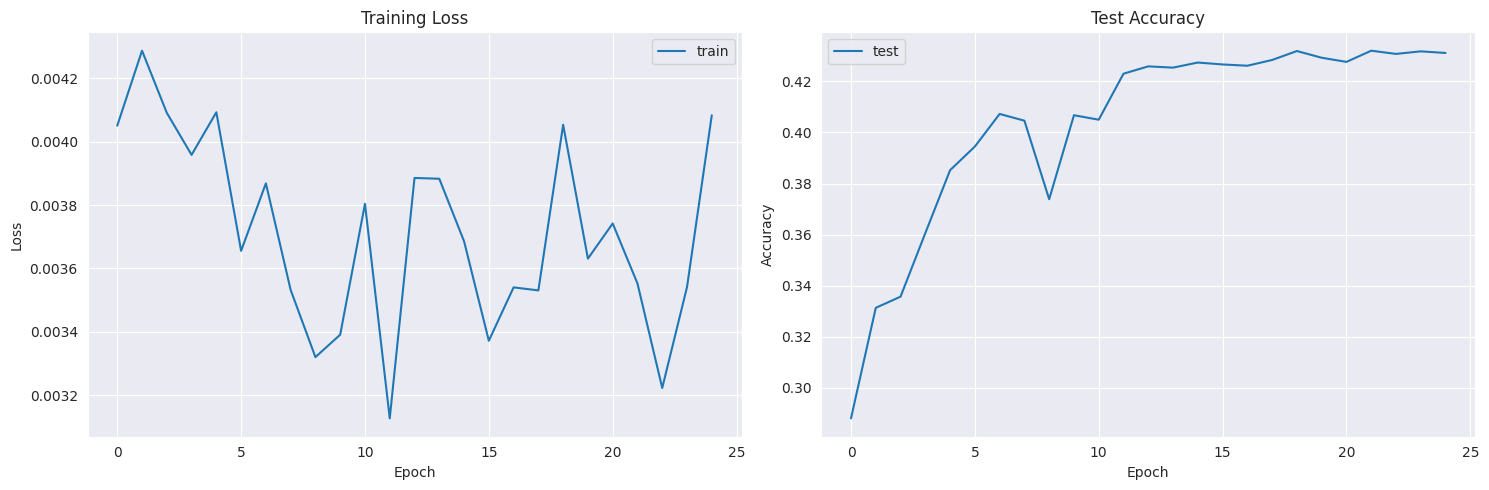

In [66]:




plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

sns.set_style(style="darkgrid")
train_hist = np.array([tensor.item() for tensor in train_hist])
sns.lineplot(data=train_hist, label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")


plt.subplot(1, 2, 2)
sns.set_style(style="darkgrid")
test_hist = np.array([tensor.item() for tensor in test_hist])
sns.lineplot(data=test_hist, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.tight_layout()
plt.show()




## Task 3: Brain Tumor Segmentation

In this task, you'll be training an AE model to segment brain tumors from patients' MRI scans. The ground truth will be the binary mask, and the output of the Decoder layer must be between 0 and 1 as well for all elements. Import the images, do preprocessing as you see fit (note that all images and their masks must be scaled to `240x240` resolution), and write an AutoEncoder Model that takes in the MRI scan as an input image and returns the binary segmentation mask of the same resolution (`1x240x240`). You'll need to ensure that the AE model is symmetrical, and account for input and output paddings for resolution consistency between inputs and outputs.

### Import the images & their masks and store them as lists

In [67]:
image_dir = '/content/tumor/images'
ground_truths_dir = '/content/tumor/masks'


# Function for preprocessing images and masks
def preprocessing(image, mask):

    # Code Here

    return None


data = []
ground_truths = []

#didnt used the above function and list, instead created custom class and transforms




class customTumor(Dataset):
    def __init__(self, image_dir, ground_truths_dir, transform=None):
        self.image_dir = image_dir
        self.ground_truths_dir = ground_truths_dir
        self.transform = transform
        self.image_paths = sorted(glob.glob(self.image_dir + '/*.png'), key = lambda x: int(x.split('/')[-1].split('.')[0]))

        self.mask_paths = sorted(glob.glob(self.ground_truths_dir + '/*.png'), key = lambda x: int(x.split('/')[-1].split('.')[0]))



    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):

        image = cv2.imread(self.image_paths[index], cv2.IMREAD_GRAYSCALE)

        mask = cv2.imread(self.mask_paths[index], cv2.IMREAD_GRAYSCALE)

        image = image.astype(np.float32) / 255.0
        mask = mask / 255.0


       


        if self.transform:
            image = self.transform(image)

            mask = self.transform(mask)
            mask = np.where(mask > 0.5, 1.0, 0.0)
            mask = torch.tensor(mask, dtype=torch.float32)
            # print(np.unique(mask))

        return image, mask

# create dataloaders
transform = transforms.Compose([

    transforms.ToTensor(),
    
    transforms.Resize((240, 240))
])

dataset = customTumor(image_dir, ground_truths_dir, transform=transform)

print(len(dataset))



3064


### Do an 80-20 train-test split & create dataloaders:

In [68]:
# Code here:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=60, shuffle=True) #total dataset small only 3000s something
test_loader = DataLoader(test_dataset, batch_size=60, shuffle=False)




### Visualize a random set of images along with their corresponding binary masks

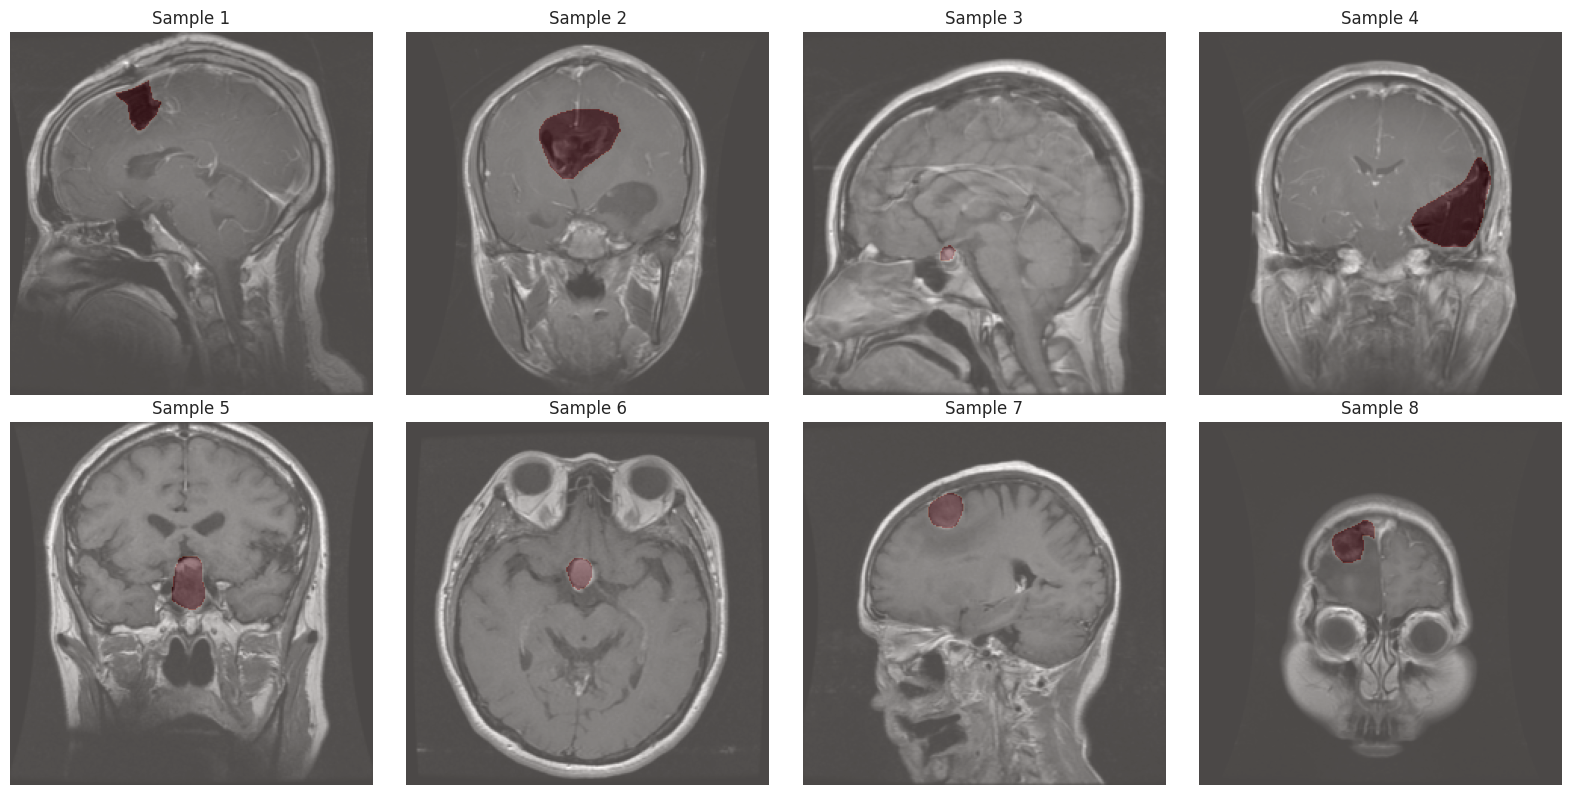

In [69]:
# Function to visualize images and masks
def visualize_samples(images, masks):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=2, ncols=num_samples // 2, figsize=(16, 8))

    for i, (image, mask) in enumerate(zip(images, masks)):
        ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
        image = image[0] ##
        mask = mask[0]
        ax.imshow(image, cmap='gray')
        ax.imshow(mask, alpha=0.3, cmap='Reds')
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()

# Select 8 random samples from the training dataset
random_indices = np.random.choice(len(train_dataset), 8, replace=False)
random_samples = [(train_dataset[i][0].numpy(), train_dataset[i][1].numpy()) for i in random_indices]

# Separate images and masks
random_images = [sample[0] for sample in random_samples]
random_masks = [sample[1] for sample in random_samples]

# Visualize the random samples
visualize_samples(random_images, random_masks)


### Create a Training Loop for segmentation tasks in `helper.py`.
Note: You must also store & return 2 sample outputs of the model after every 5 epochs. We'll use them to visualize how the model learns to segment the images over the training process.

#### For segmentation tasks, an MSE Loss function, while usable, often performs poorly. Your next task is to implement the Dice Loss using a custom `DiceLoss` class.


$\text{Given a predicted mask }  p \text{ and the ground truth target } t, \text{ with a smoothing factor } s, \text{ the Dice Loss } L \text{ is defined as:}$

#### $L = 1 - \frac{2 \cdot \sum(p \cdot t) + s}{\sum(p^{2}) + \sum(t^{2}) + s}$

The smoothing factor is a very small number added to avoid division by 0. You can read more about Dice Loss [here](https://arxiv.org/pdf/1606.04797.pdf) (on page 6).


In [70]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, prediction, target, smooth=1e-6):

        loss = 1 - (2 * torch.sum(prediction * target) + smooth) / (torch.sum(prediction**2) + torch.sum(target**2) + smooth)
        return loss



### Create an AutoEncoder Model for Brain Tumor Segmentation

In [71]:

class EncoderDecoderCNN(nn.Module):
    def __init__(self):
        super(EncoderDecoderCNN, self).__init__()
#240x240
        self.down_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        #120

        self.down_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        #60

        self.down_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
            #30
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up_trans1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)

        self.up_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.up_trans2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)

        self.up_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.up_trans3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2)

        self.up_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.out = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
        

    def forward(self, x):

        
        x1 = self.down_conv1(x)
        x = self.pool(x1)
        x2 = self.down_conv2(x)
        x = self.pool(x2)
        x3 = self.down_conv3(x)
        x = self.pool(x3)
        x = self.bottleneck(x)

       
        x = self.up_trans1(x)
       
        x = torch.cat([x, x3], dim=1)
        x = self.up_conv1(x)
        x = self.up_trans2(x)
        
        x = torch.cat([x, x2], dim=1)
        x = self.up_conv2(x)
        x = self.up_trans3(x)
        
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv3(x)

        x = self.out(x)
        
        return x











In [72]:
# load the model
model = EncoderDecoderCNN()
model.to(device)
summary(model, input_size=(1, 240, 240), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 16, 240, 240]             160
       BatchNorm2d-2        [128, 16, 240, 240]              32
              ReLU-3        [128, 16, 240, 240]               0
            Conv2d-4        [128, 16, 240, 240]           2,320
       BatchNorm2d-5        [128, 16, 240, 240]              32
              ReLU-6        [128, 16, 240, 240]               0
         MaxPool2d-7        [128, 16, 120, 120]               0
            Conv2d-8        [128, 32, 120, 120]           4,640
       BatchNorm2d-9        [128, 32, 120, 120]              64
             ReLU-10        [128, 32, 120, 120]               0
           Conv2d-11        [128, 32, 120, 120]           9,248
      BatchNorm2d-12        [128, 32, 120, 120]              64
             ReLU-13        [128, 32, 120, 120]               0
        MaxPool2d-14          [128, 32,

### Train your Model & Plot the Loss History:

In [73]:
criterion = DiceLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
#./PA3-2_Part2_Task3_tumor_seg_24100043.pth
model_path = "/content/tumor_segmentation.pth" # change this
model.to(device)
train_hist, test_hist, sample_outputs = training_loop_segmentation(model, train_loader, test_loader, num_epochs,
                                                 criterion, optimizer, device, model_path)



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 0.010166
Validation Loss: 0.018912
Epoch: 2/20, Train Loss: 0.007716
Validation Loss: 0.011407
Epoch: 3/20, Train Loss: 0.007691
Validation Loss: 0.009908
Epoch: 4/20, Train Loss: 0.006518
Validation Loss: 0.008486
Epoch: 5/20, Train Loss: 0.004654
Validation Loss: 0.006672
Epoch: 6/20, Train Loss: 0.006039
Validation Loss: 0.006328
Epoch: 7/20, Train Loss: 0.004890
Validation Loss: 0.007459
Epoch: 8/20, Train Loss: 0.004419
Validation Loss: 0.006501
Epoch: 9/20, Train Loss: 0.004335
Validation Loss: 0.005968
Epoch: 10/20, Train Loss: 0.003195
Validation Loss: 0.005862
Epoch: 11/20, Train Loss: 0.002972
Validation Loss: 0.007519
Epoch: 12/20, Train Loss: 0.003355
Validation Loss: 0.005739
Epoch: 13/20, Train Loss: 0.002842
Validation Loss: 0.006543
Epoch: 14/20, Train Loss: 0.003621
Validation Loss: 0.005775
Epoch: 15/20, Train Loss: 0.002764
Validation Loss: 0.005804
Epoch: 16/20, Train Loss: 0.002603
Validation Loss: 0.006306
Epoch: 17/20, Train Loss: 0.00154

In [74]:
def visualize_sample_outputs(sample_outputs):
    """
    Visualizes sample outputs (images, predicted masks, and ground truth masks) in a single row for each set of samples.

    Args:
    - sample_outputs: List of dictionaries containing images, predicted masks, and ground truth masks for sample outputs.
    """

    for samples in sample_outputs:
        num_samples = len(samples)
        num_cols = num_samples * 3  # Three columns per sample (image, predicted mask, ground truth mask)

        fig, axs = plt.subplots(1, num_cols, figsize=(num_samples * 6, 4))

        for i, sample in enumerate(samples):

            image = sample['image'].squeeze().numpy()
            predicted_mask = sample['predicted_mask'].squeeze().numpy() #
            ground_truth_mask = sample['ground_truth_mask'].squeeze().numpy()

            # Plotting image
            axs[i * 3].imshow(image, cmap='gray')
            axs[i * 3].set_title(f'Image {i+1}')
            axs[i * 3].axis('off')

            # Plotting predicted mask
            axs[i * 3 + 1].imshow(predicted_mask, cmap='gray')
            axs[i * 3 + 1].set_title(f'Predicted Mask {i+1}')
            axs[i * 3 + 1].axis('off')

            # Plotting ground truth mask
            axs[i * 3 + 2].imshow(ground_truth_mask, cmap='gray')
            axs[i * 3 + 2].set_title(f'Ground Truth {i+1}')
            axs[i * 3 + 2].axis('off')

        plt.tight_layout()
        plt.show()


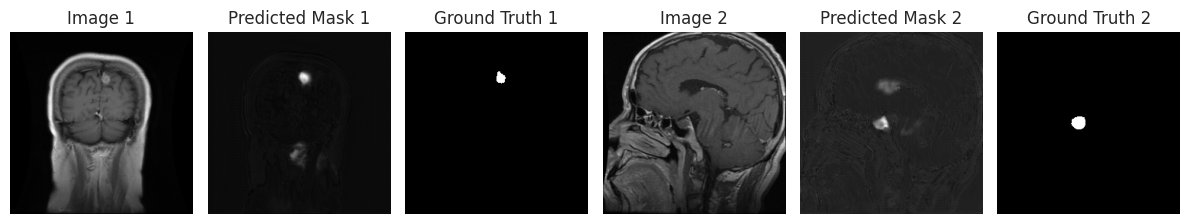

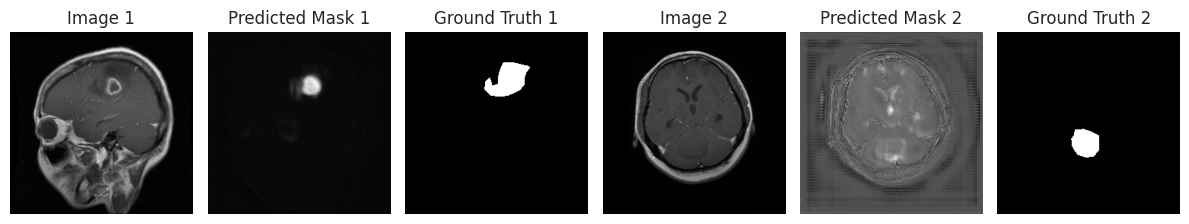

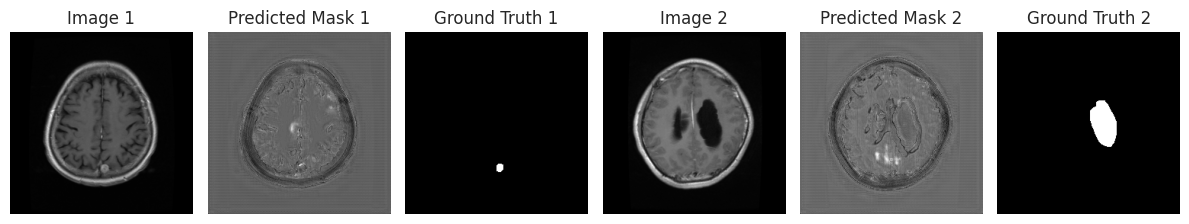

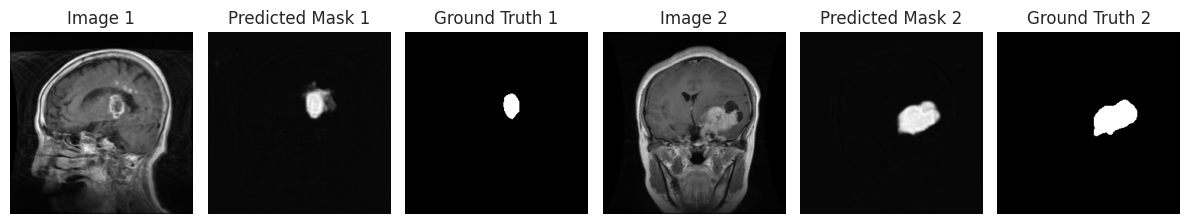

In [75]:

visualize_sample_outputs(sample_outputs)


#### Use the IoU and DICE Coefficient to evaluate your model (Read [here](https://medium.com/mlearning-ai/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f)):

In [76]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [77]:
true = []
pred = []
for imgs, mask in test_loader:
    true.extend([m.cpu().numpy().reshape(1, 240, 240) for m in mask])
    with torch.no_grad():
        imgs = imgs.reshape(-1, 1, 240, 240).cuda()
        outputs = model(imgs).detach().cpu().numpy()
    pred.extend([m for m in outputs])

true = np.array(true)
pred = np.array(pred)

In [78]:
print("Dice coefficient is:",dice_coef(true,pred))
print("IoU:", iou(true,pred))

Dice coefficient is: 0.776
IoU: 0.633
